### Creating micrograd for back propagation and tracing a equation through its values


In [2]:
pip install numpy matplotlib # type: ignore

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#'

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



In [4]:
def f(x): #this is going to be an example of a function that takes in x and returns y as a result of a function
    return (4*x**2)- 3*x+5

In [5]:
f(3.0) 

32.0

In [6]:
a_few_x = np.arange(-5,5,0.25) #this will generate a few values for x using numpy and set the range from -5 to 5 with 0.25 step up
# a_few_x
a_few_y = f(a_few_x)
a_few_y

array([120. , 109.5,  99.5,  90. ,  81. ,  72.5,  64.5,  57. ,  50. ,
        43.5,  37.5,  32. ,  27. ,  22.5,  18.5,  15. ,  12. ,   9.5,
         7.5,   6. ,   5. ,   4.5,   4.5,   5. ,   6. ,   7.5,   9.5,
        12. ,  15. ,  18.5,  22.5,  27. ,  32. ,  37.5,  43.5,  50. ,
        57. ,  64.5,  72.5,  81. ])

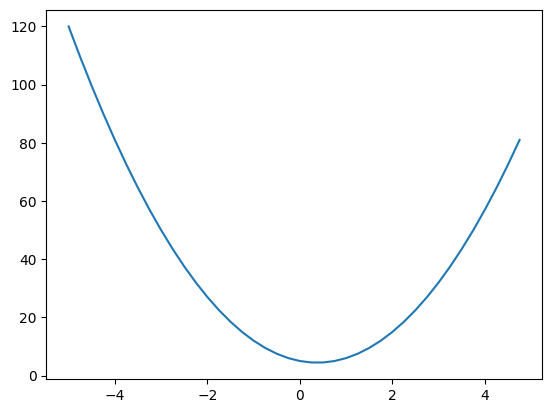

In [7]:
plt.plot(a_few_x,a_few_y) #plotting the graph of an quadratic eqn.

In [8]:
h = 0.000000000000001
x= 3
print(f(x+h))
(f(x+h) -f(x))/h #derivative calculation

32.000000000000014


14.210854715202002

In [9]:
a = 2.0
b = -3.0
c = 10.0
d= a*b+c
d  

4.0

In [10]:
h = 0.00001
a = 2.0
b = -3.0
c = 10.0
d1= a*b+c
c= c+h
d2 = a*b + c
print("d1",d1)
print("d2",d2)
print("slope",(d2-d1)/h)

d1 4.0
d2 4.00001
slope 0.9999999999621422


## Now we will write the value object for micrograd

In [65]:
class Value:
    def __init__(self,data,_children= (),_op='',label=''):
        self._backward = lambda:None
        self.data = data
        self.grad = 0.0 # 0 denotes change in the value doesn't affect the loss function
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        out = Value(self.data + other.data,(self,other),'+')\
            
        #_backward() takes out's grad and then we propagate it to self's grad and then the other's grad 
        def _backward():
            self.grad = 1.0 *out.grad
            other.grad = 1.0 *out.grad
                 
        out._backward = _backward
        return out
    def __mul__(self,other):
        out = Value(self.data * other.data,(self,other),'*')
        def _backward():
            self.grad = other.data *out.grad
            other.grad = self.data *out.grad
                 
        out._backward = _backward
        
        return out
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t,(self,),'tanh')
        
        def _backward():
            self.grad = (1- t**2) * out.grad
        out._backward = _backward
        return out
    def backward(self):
        ## FYI we recalled the draw_dot() ,method everytime in above _backward steps
        #its time to get rid of the manual calling by doing a topological sort

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [12]:
a = Value(2.0,label='a')
b = Value(-3.0,label='b')
e = a*b
e.label = 'e'
c = Value(10.0,label='c')
d= e + c
d.label = 'd'
f = Value(-2.0,label='f')
L = d*f
L.label= 'L'
L

Value(data=-8.0)

### visualizing the graph between values

In [13]:
pip install graphviz # type: ignore

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#'

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
from graphviz import Digraph

def trace(root):
    nodes,edge = set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edge.add((child,v))
                build(child)
    build(root)
    return nodes,edge

def draw_dot(root):
    dot = Digraph(format="svg",graph_attr={'rankdir': 'LR'}) #this would mean left to right 
    nodes,edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid,label="{%s | data %.4f |  grad %.4f }"  % (n.label,n.data,n.grad), shape='record') 
        if n._op:
            dot.node(name=uid+n._op,label=n._op)
            dot.edge(uid +n._op,uid)
    for n1,n2 in edges:
        dot.edge(str(id(n1)),str(id(n2)) +n2._op)
    return dot   

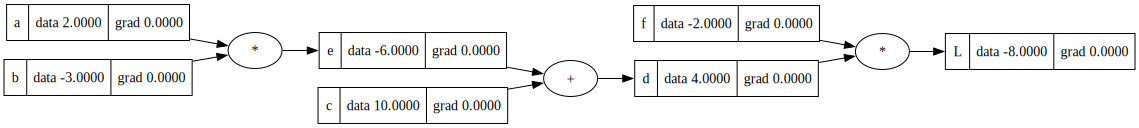

In [15]:
draw_dot(L)

now we need to do 
L = d*f
so we get 
dL/dd = f
how did we get this:
(f(x+h) - f(x))/h
now 
((d+h) *f - d*f)/h
(df +hf - df) / h
df cancells out
we get
hf/h
so f

so dl/df = d and dl/dd = f

In [16]:
f.grad = 4.0 #value of d
d.grad = -2.0 # value of f
L.grad = 1.0 # dl/dl = 1
c.grad = -2.0 #(explained below)
# now similarily e will also be
e.grad = -2.0
a.grad = -3.0 * -2.0
b.grad = 2.0 *-2.0 
# also we understand than any plus node will simply distribute 
# the nodes values to the leaf nodes and thus passing on the same values 
# so here we can say that since d is linked through the plus node with c and e 
# we get the value repeated there in there grad values

#### we are able to build out mathematical expression, using only scalar values and + and - signs and we can do a forward pass, and trace the expression that produces the output L
#### forward propagation, now we we do back propagation finding derivatives with respect to different values


now we need to find dl/dc for that we need to understand chain rule (see notebook),
but essentially it means 
dl/dc = dl/dd * dd/dc
we know dl/dd = -2.0
also dd/dc = 1.0
so dl/dc = -2.0 or f

now we need the final nodes, dl/de = -2 we know this
we want dl/da , so chain rule says
dl/de = dl/de *de/da
so if we solve this de/da we get d(ab)/da = b and then a for d(ab)/db 

In [17]:
def derive():
    a = Value(2.0,label='a')
    b = Value(-3.0,label='b')
    e = a*b
    e.label = 'e'
    c = Value(10.0,label='c')
    d= e + c
    d.label = 'd'
    f = Value(-2.0,label='f')
    L = d*f
    L.label= 'L'
    L1 = L.data
    # print(L1)
    h = 0.001
    a = Value(2.0,label='a')
    b = Value(-3.0,label='b')
    e = a*b
    c = Value(10.0,label='c')
    c.data+=h
    d= e + c
    d.label = 'd'
    e.label = 'e'
    f = Value(-2.0,label='f')
    L = d*f
    L.label= 'L'
    L2 = L.data
    print("result",(L2-L1)/h)

In [18]:
derive()

result -1.9999999999988916


In [66]:
x1 = Value(2.0,label="x1")
x2 = Value(0.0,label="x2")
w1 = Value(-3.0,label="w1")
w2 = Value(1.0,label="w2")
b = Value(6.8813735870195432,label="b")
x1w1 = x1*w1 ; x1w1.label="x1w1"
x2w2 = x2*w2 ; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 +x2w2; x1w1x2w2.label="x1w1 + x2w2"
n = x1w1x2w2 +b; n.label='n'
o = n.tanh()
o.label = 'o'




In [31]:

## now we need to find derivative of o w.r.t to the rest of the things
# so we begin with do/do = 1, then we back propagate and we need do/dn
# we know do/dn = d(tanh)/dn = 1- tanh**2(h)
# then we have tan h = o
# 1- o**2
1- o.data **2


n.grad = 0.5
## now we also now plus is just a distributor of gradient,so it will just flow down
b.grad = n.grad
x1w1x2w2.grad = n.grad
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad
# now we have the first nodes since they are x1,w1,x2,w2, we have chain rule here
x2.grad = x2w2.grad* w2.data 
w2.grad = x2w2.grad* x2.data 
x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data





0.4999999999999999

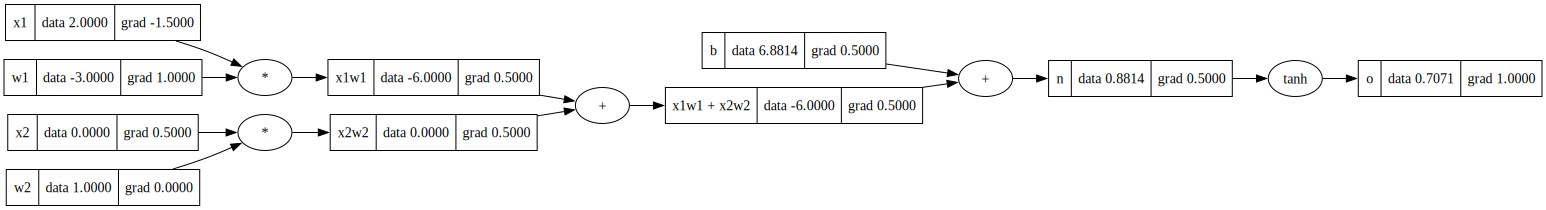

In [69]:
draw_dot(o)

In [68]:
# now we wrote the backward function so we are going to call it in the order it is supposed to be
o.grad = 1.0

o.backward()

In [ ]:
o._backward()

In [49]:
n._backward()

In [51]:
b._backward()

In [53]:
x1w1x2w2._backward()

In [55]:
x1w1._backward()

In [58]:
x2w2._backward()

[Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]